In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import IPython

import utils
from dataset_generator import DatasetGenerator

os.chdir('..') 

2023-04-26 15:27:14.531530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 15:27:15.622195: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
price_dfs = utils.load_data('prices')
quarterly_financials_dfs = utils.load_data('quarterly_financials')

dfs = []
for (price_df, quarterly_financials_df) in zip(price_dfs, quarterly_financials_dfs):
    price_df = utils.clean_price_df(price_df)
    quarterly_financials_df = utils.clean_quarterly_financials_df(quarterly_financials_df)

    df = utils.join_quarterly_financials_df(price_df, quarterly_financials_df)

    df = df.drop(["Date", "end_date"])

    dfs.append(df)

train_dfs, val_dfs, test_dfs = utils.setup_data(dfs, .7, .2)

column_indices = {name: i for i, name in enumerate(train_dfs[0].columns)}


argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    
argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    
argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    
argument in operation 'asof_join' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an 

In [3]:
label_columns = ['Adj Close']

single_step_window = DatasetGenerator(train_dfs, val_dfs, test_dfs, 1, 1, 1, label_columns)

wide_window = DatasetGenerator(train_dfs, val_dfs, test_dfs,  20, 20, 1, label_columns)

CONV_WIDTH = 3
conv_window = DatasetGenerator(train_dfs, val_dfs, test_dfs, CONV_WIDTH, 1, 1, label_columns)

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = DatasetGenerator(train_dfs, val_dfs, test_dfs, INPUT_WIDTH, LABEL_WIDTH, 1, label_columns)

2023-04-26 15:27:17.189638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-26 15:27:17.229246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-26 15:27:17.229623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Baseline

In [4]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [5]:
baseline = Baseline(label_index=column_indices['Adj Close'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


2023-04-26 15:27:21.773504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_77' with dtype int32
	 [[{{node Placeholder/_77}}]]
2023-04-26 15:27:21.776613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_109' with dtype int32
	 [[{{node Placeholder/_109}}]]


115/115 [==============================] - 1s 4ms/step - loss: 0.0198 - mean_absolute_error: 0.0928


2023-04-26 15:27:22.567419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_103' with dtype int32 and shape [353]
	 [[{{node Placeholder/_103}}]]
2023-04-26 15:27:22.570016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_31' with dtype double and shape [354,13]
	 [[{{node Placeholder/_31}}]]


In [6]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

2023-04-26 15:27:23.347512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2480]
	 [[{{node Placeholder/_8}}]]
2023-04-26 15:27:23.348141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


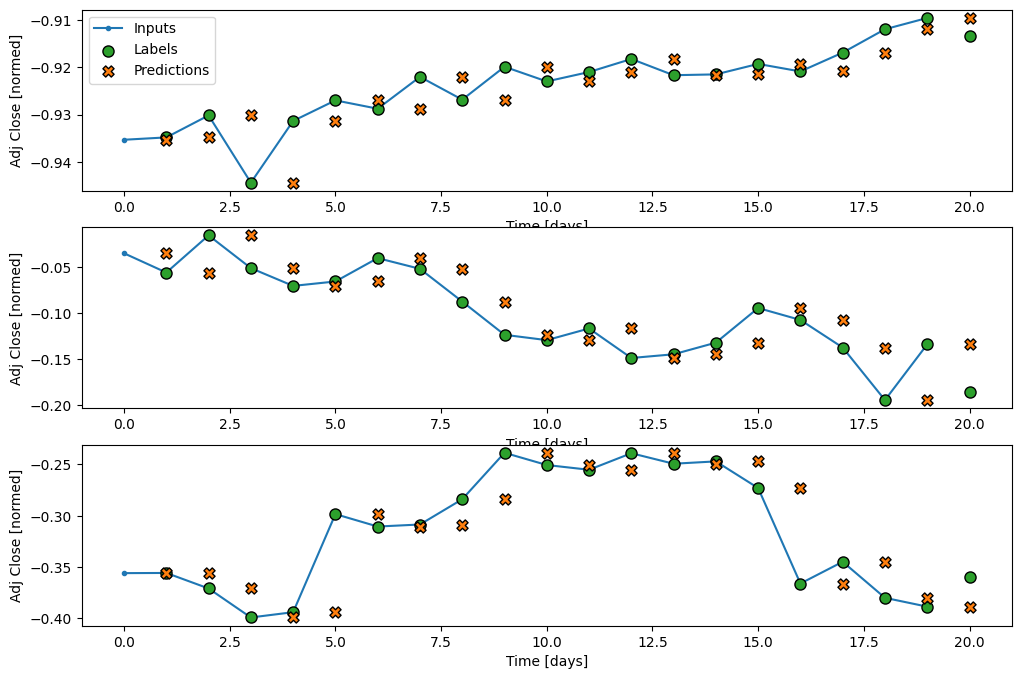

In [7]:
wide_window.windows[0].plot(baseline)

### Linear

In [8]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [9]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20


2023-04-26 15:27:24.661463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_95' with dtype double and shape [2472,13]
	 [[{{node Placeholder/_95}}]]
2023-04-26 15:27:24.663339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-26 15:27:25.988700: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x22b65100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-26 15:27:25.988739: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Co

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_1' defined at (most recent call last):
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_19862/353930671.py", line 1, in <module>
      history = compile_and_fit(linear, single_step_window)
    File "/tmp/ipykernel_19862/2820204216.py", line 12, in compile_and_fit
      history = model.fit(window.train, epochs=MAX_EPOCHS,
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 543, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 650, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1200, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1250, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/zach/miniconda3/envs/stocksai/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1245, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_1'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_1}}]] [Op:__inference_train_function_6996]

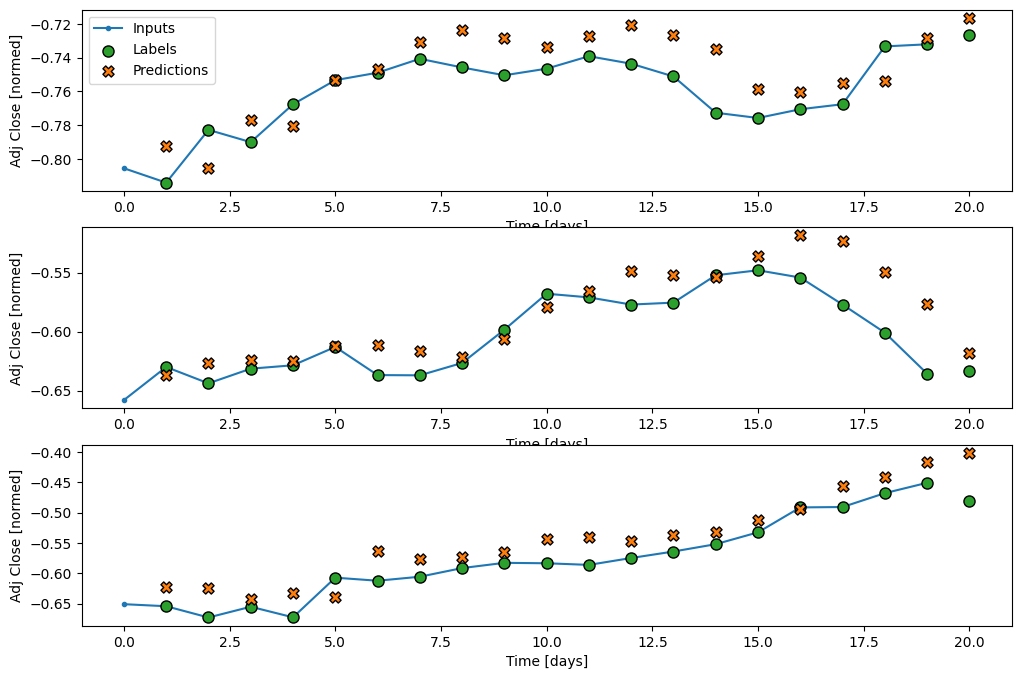

In [ ]:
wide_window.windows[0].plot(linear)

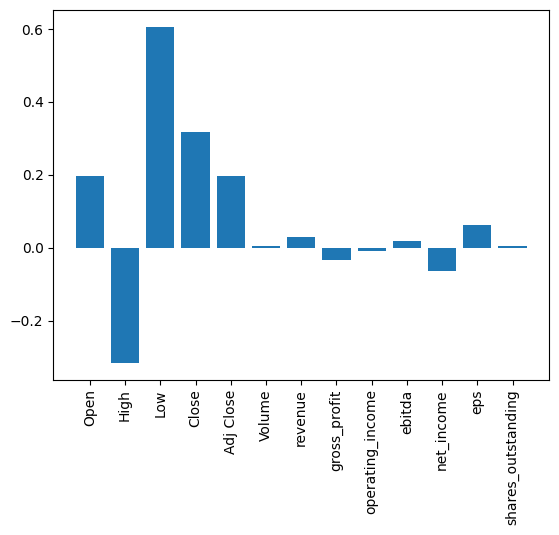

In [ ]:
plt.bar(x = range(len(train_dfs[0].columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_dfs[0].columns)))
_ = axis.set_xticklabels(train_dfs[0].columns, rotation=90)

### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
391/391 [==============================] - 3s 6ms/step - loss: 0.0105 - mean_absolute_error: 0.0520 - val_loss: 0.0465 - val_mean_absolute_error: 0.1649
Epoch 2/20
391/391 [==============================] - 3s 8ms/step - loss: 0.0016 - mean_absolute_error: 0.0261 - val_loss: 0.0803 - val_mean_absolute_error: 0.2098
Epoch 3/20
115/115 [==============================] - 1s 8ms/step - loss: 0.0738 - mean_absolute_error: 0.2076


### Multi-step Dense

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

111/111 [==============================] - 0s 2ms/step - loss: 0.0689 - mean_absolute_error: 0.1975


2023-04-26 15:09:59.226498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_103' with dtype int32 and shape [351]
	 [[{{node Placeholder/_103}}]]
2023-04-26 15:09:59.227803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_135' with dtype int32 and shape [351]
	 [[{{node Placeholder/_135}}]]


2023-04-26 15:09:59.712992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2500,13]
	 [[{{node Placeholder/_0}}]]
2023-04-26 15:09:59.713492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2500,13]
	 [[{{node Placeholder/_0}}]]


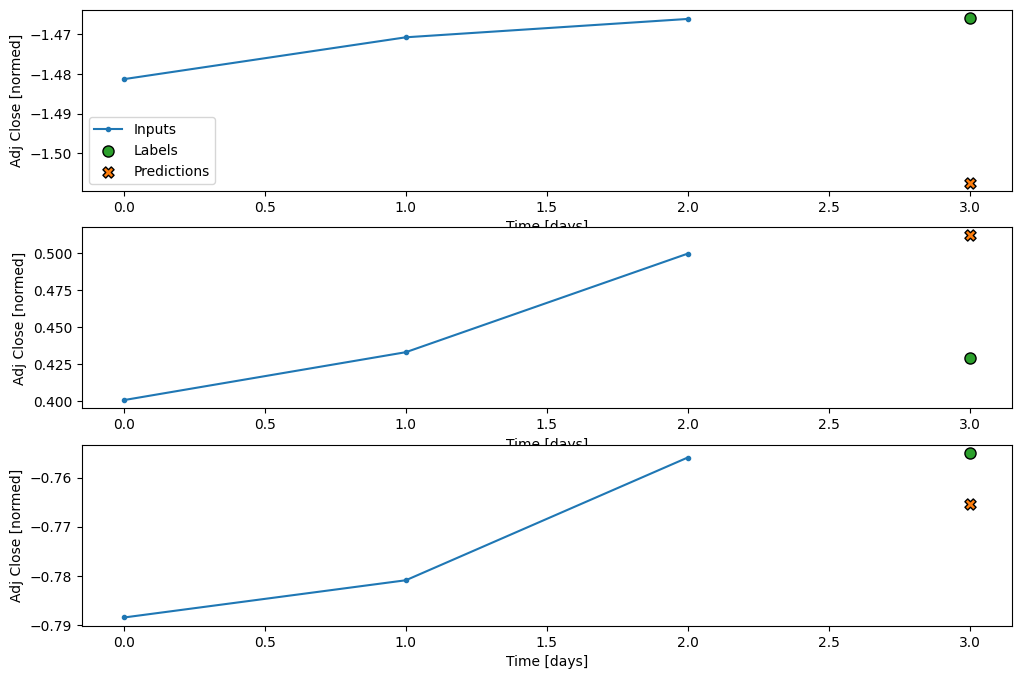

In [ ]:
conv_window.windows[0].plot(multi_step_dense)

### Convolutional Neural Network

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

111/111 [==============================] - 1s 7ms/step - loss: 0.1293 - mean_absolute_error: 0.2754


2023-04-26 15:10:18.073944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2500,13]
	 [[{{node Placeholder/_0}}]]
2023-04-26 15:10:18.074397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2500,13]
	 [[{{node Placeholder/_0}}]]


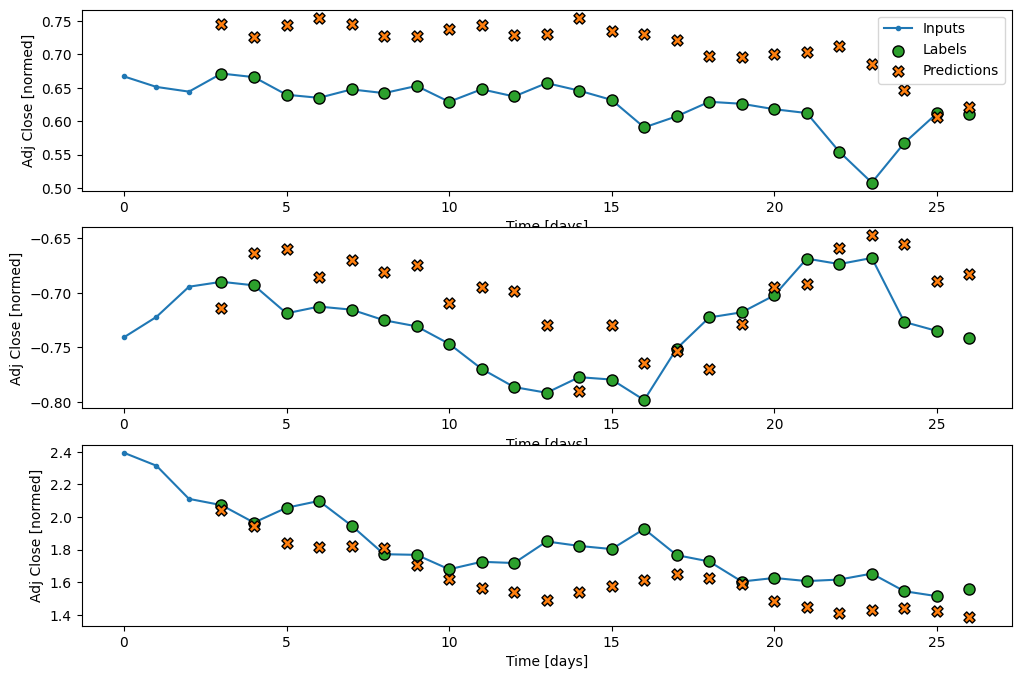

In [ ]:
wide_conv_window.windows[0].plot(conv_model)

### LSTM

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(4, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

110/110 [==============================] - 1s 7ms/step - loss: 6.7369 - mean_absolute_error: 1.7176


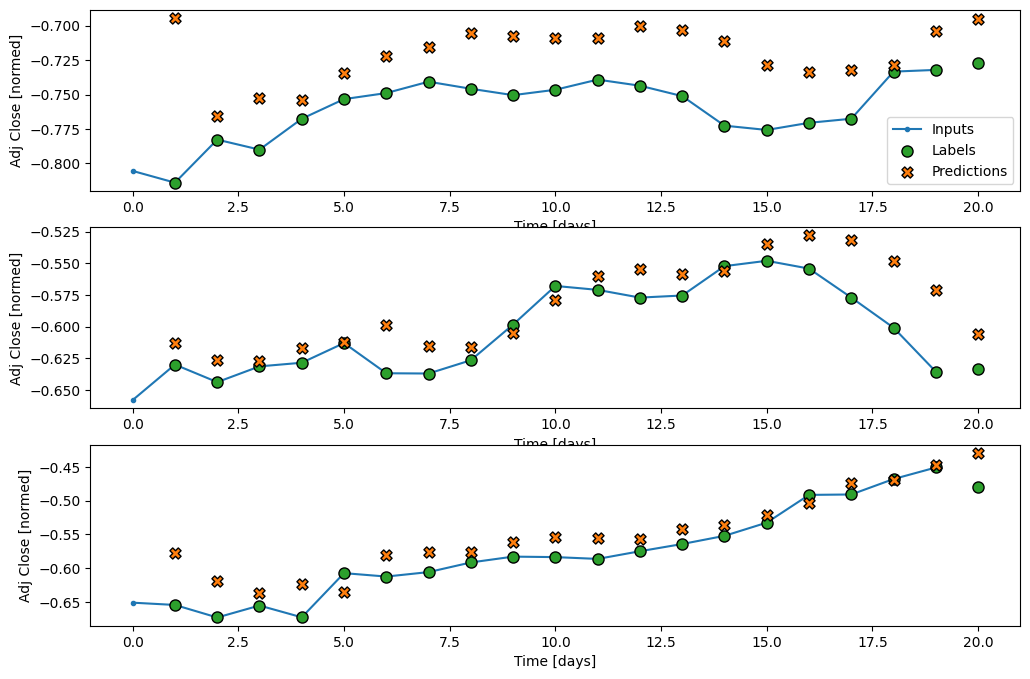

In [ ]:
wide_window.windows[0].plot(lstm_model)

## Performance

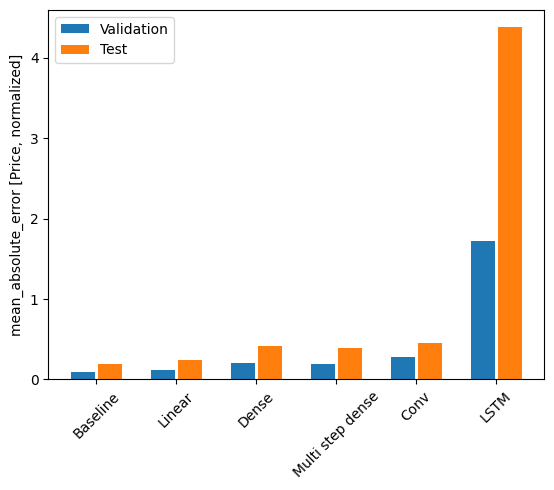

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
